In [1]:
# using Revise
ENV["GKS_ENCODING"] = "utf-8"
ENV["JULIA_CUDA_SILENT"] = 1

using JSON3, DataFrames, Plots, Dates, StatsPlots, LsqFit, Query
using DifferentialEquations, Flux, DiffEqFlux
import StatsBase

┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1273


In [2]:
function time_from_filename(filename)
    dtime_string = match(r"-(.*)\.", filename)[1]
    DateTime(dtime_string, dateformat"yyyy-mm-dd_HH:MM:SS")
end

function total_from_file(path)
    txt = open(path) |> read |> String
    num = try
        parse(Int, match(r"confirmedCount.*?([0-9]*),", txt)[1])
    catch
        parse(Int, match(r"确诊\s?([0-9]*)\s?例", txt)[1])
    end
    
    if num< 100
        @show path
    end
    return num
end

function js_to_CN_provinces(filename)
    dict = JSON3.read(open(filename) |> read |> String)[:data]
    return dict[:statistics], dict[:listByCountry]
end

function CN_statistics_cleaning(CN)
    if haskey(CN, :confirmedCount)
        return Dict(
            "confirmed" => CN[:confirmedCount],
            "suspected" => CN[:suspectedCount],
            "dead" => CN[:deadCount]
        )
    else
        mark_txt = CN[:countRemark]
        return Dict(
            "confirmed" => 
            parse(Int, match(r"确诊\s?([0-9]*)\s?例", mark_txt)[1]),
            "suspected" => 
            parse(Int, match(r"疑似\s?([0-9]*)\s?例", mark_txt)[1]),
            "dead" => 
            parse(Int, match(r"死亡\s?([0-9]*)\s?例", mark_txt)[1])
        )
    end
end

function html_countrylist(filename)
    content = open(filename) |> read |> String
    if !occursin("""<body><script id="getAreaStat">try { window.getAreaStat""", content)
        return []
    end
    new_js_str = match(r"window.getAreaStat\s=\s(.*}])}catch", content)[1]
    JSON3.read(new_js_str)
end

function hour_since_day0(date, day0=DateTime(2020, 1, 11, 0, 0, 0))
    floor(date - day0, Hour) |> Dates.value |> Int
end

function time_series(df)
    df = unique(df, 1)
    times = df[!, :time]
    return times, df[!, :confirmed]
end

function fit_log(xs, ys)
    @. model(x, p) = p[1] + p[2]*x
    fit = curve_fit(model, xs, log10.(ys), [1.0, 1.0])
    prediction(x) = model(x, coef(fit))
    return prediction
end

fit_log (generic function with 1 method)

In [3]:
function produce(all_provinces, all_keys, dict_of_provinces; before = Date("2020-12-31"), ann=false, future_days = 1)
    before = DateTime(before)
    START_TIME = DateTime(2020, 1, 23, 15, 0, 0)
    plot()
    Now = min(now(), before)
    time_window = [START_TIME, Now+future_days*Hour(24)]
    smooeth_time = range(hour_since_day0.(time_window)..., length=100)
    big_palette = vcat(palette(:default), palette(:inferno), palette(:viridis))
    for i in 1:length(all_provinces)
        prov_name = all_provinces[i]
        df = unique(DataFrame(dict_of_provinces[prov_name]), 1) |>
             @filter(_.time < before)|>
             DataFrame
        
        times = hour_since_day0.(df[!, :time])
        for key in all_keys
            nums = Int.(df[!, key])
            nums_text = string.(nums)
            prediction = fit_log(times, nums)
            color = convert(HSL, big_palette[i])
            if key != :confirmed
                color = (color.h, color.s * 0.7, color.l * 0.7, 0.5)
                color = HSLA(color...)
            end
            smooeth_num = 10 .^prediction.(smooeth_time)
            @df df scatter!(times, nums, color = color
                , label = "$prov_name $(key |> String)", markersize=3, markeralpha = 0.5)
            if(ann>0)
                num_ann = ann-1
                for (t,c,txt) in zip(times[end-num_ann:end], nums[end-num_ann:end], nums_text[end-num_ann:end])
                    annotate!(t+3, c*0.99, (txt, :top, 9))
                end
            end
            @df df plot!(smooeth_time, smooeth_num, label="Log10 Fit ", color=color, linestyle=:dot, linewidth=3)
        end
    end
        
    label_time = [
        START_TIME + Day(x) 
        for x = 0:floor(time_window[2] - time_window[1], Day).value
        ]

    labels = map(x->"$(month(x))/$(day(x))", label_time)
    label_time = hour_since_day0.(label_time)
    plot!(legend=:topleft,
#         fmt = :svg,
        legendfontsize = 5,
        xlabel = "Date",
        xrotation=50,
        ylabel = "Dead",
        xticks=(label_time, labels),
#         minorgrid = true,
#         minorticks = 2
    )
end

produce (generic function with 1 method)

In [4]:
all_js_files = [joinpath(r, f) for (r, dirs, files) in walkdir("./js") for f in files if filesize(joinpath(r, f))>1000];
# all_html_files = [joinpath(r, f) for (r, dirs, files) in walkdir("./Wuhan") for f in files if filesize(joinpath(r, f))>100];
js_fields = [
    "confirmed",
#     "suspected",
#     "healed",
    "dead",
]
# html_fields = [
#     "confirmedCount",
#     "suspectedCount",
#     "curedCount",
#     "deadCount",
# ]
all_provinces = [
    entry["provinceShortName"]
    for entry in js_to_CN_provinces(all_js_files[end])[2]
        ]
pushfirst!(all_provinces, "全国")

dict_of_provinces = Dict(p => Dict(f => [] for f in vcat("time", js_fields)) for p in vcat("全国", all_provinces))
for f in all_js_files
    Time = time_from_filename(f)
    CN, country_list = try
        js_to_CN_provinces(f) #some js file corrupted
    catch
        continue
    end
    CN_nums = CN_statistics_cleaning(CN)
    @debug CN_nums
    
    for field in js_fields
        push!(dict_of_provinces["全国"][field], CN_nums[field])
    end
    push!(dict_of_provinces["全国"]["time"], Time)
    
    for entry in country_list
        if "待明确地区" == entry["provinceShortName"] continue end
        for field in js_fields
            push!(
                dict_of_provinces[entry["provinceShortName"]][field],
                field in keys(entry) ? entry[field] : missing
                )
        end
        push!(
            dict_of_provinces[entry["provinceShortName"]]["time"],
            Time
        )
    end
end

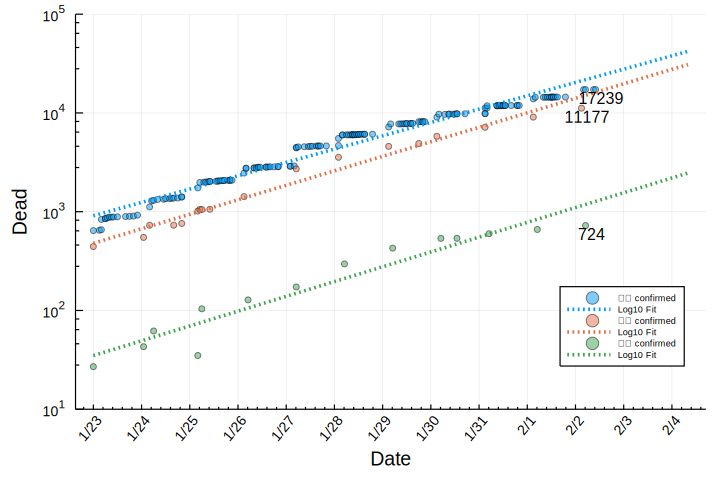

In [5]:
d_range = range(DateTime("2020-1-24"), DateTime("2020-1-31"), step=Hour(1))
# t1 = time()
# anim = @animate for i in d_range
        produce([
                "全国",
                "湖北",
#                 "北京",
#                 "上海",
                "浙江",
#                 "广东",
#                 "福建"
                ], [:confirmed],
        dict_of_provinces,
#         before = i,
        ann=1, future_days=2)
#         plot!(legend=:bottomright, ylims = (1,14000), minorticks=true, dpi=120)
        plot!(legend=:bottomright, ylims = (10,10^5), minorticks=true, dpi=120, yscale=:log10)

        # plot!(minorgrid = true, minorticks = 5)
        # hline!([1.386*10^9], color=:grey, linestyle=:dash, label="")
        # annotate!(460, 10^9, text("Population of PRC", :top, 10, :grey))
#     end

# gif(anim, "/tmp/anim_corona.gif", fps = 10)

In [6]:
function sir_ode!(du,u,p,t)
    S,I,R = u #subseptable, infected, recovered
    β, γ = p
    du[1] = -β*S*I
    du[2] = β*S*I-γ*I
    du[3] = γ*I
end
Ts, Is = time_series(dict_of_provinces["湖北"] |> DataFrame)
# convert times to hours for granular fitting
times = Ts .|> hour_since_day0
# off set to 0
times .-= times[1]

# initial SIR parameter and time span we want to consider
parms = [0.03,0.006]
tspan = (0.0, 1200)
total_population = 0.6*10^5
# normalize assume total suseptable populartion is ~ 0.5 million
Is /= total_population
# log extrapolation function, we can discard this once we have enough data points

#     @. model(x, p) = p[1] + p[2]*x
@. model(x, p) = p[1] + p[2]*x + p[3]*x^2 + p[4]*x^3
fit = curve_fit(model, times, Is, [1.0, 1.0, 1.0, 1.0])
extrap(x) = model(x, coef(fit))

extrap (generic function with 1 method)

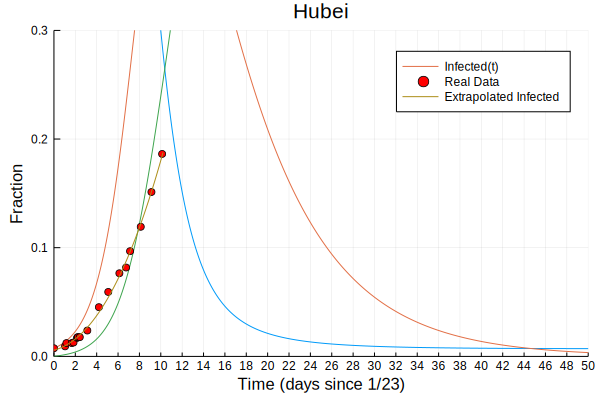

In [7]:

# initial S I R, based on fraction of population
init = [1-Is[1], Is[1],0.0]

# solve it for once
prob = ODEProblem(sir_ode!, init, tspan, parms)
sol = solve(prob, Tsit5())
plot(sol, xlabel="Time (days since 1/23)", ylabel="Fraction", yrotation=0,
    xticks = (range(tspan..., step=48), range(0, tspan[2]÷24, step=2)),
    label = ["" "Infected(t)" ""])
scatter!(times, Is, color=:red, label = "Real Data")

# extrapolated data
t_points = 0:0.5:245
I_points = extrap.(t_points)
plot!(t_points, I_points, label = "Extrapolated Infected")
ylims!((-0.0001, 0.3))
title!("Hubei")

In [8]:
function predict_adjoint() # Our 1-layer neural network
  Array(concrete_solve(prob, Tsit5(), init, parms, saveat=t_points))
end
wgts = StatsBase.eweights(I_points |> length, 0.02)
function loss_adjoint()
    diff = I_points .- predict_adjoint()[2, :]
    loss = sum(abs2.(diff) .* wgts) # our loss function
    loss += StatsBase.mean(diff) * wgts[end] * abs(init[1] - (1-Is[1])) # make initial number fix more importatn
end

# update parms using black magic
data = Iterators.repeated((), 360)
opt = ADAM(0.004)
cb() = @show init[1], parms, loss_adjoint()
Flux.train!(loss_adjoint, Flux.params(init, parms), data, opt, cb=Flux.throttle(cb, 5))

(init[1], parms, loss_adjoint()) = (0.9886000000000036, [0.02600000000000015, 0.009999999999999926], 89.97744061035586)
(init[1], parms, loss_adjoint()) = (0.9794096233365039, [0.03465454441681609, 0.017519569447106965], 14.951917696557782)
(init[1], parms, loss_adjoint()) = (0.9780440217286556, [0.02931887036130193, 0.012315172594686983], 0.17178631002549288)
(init[1], parms, loss_adjoint()) = (0.9785065064731258, [0.029209699475813002, 0.011816967568074497], 0.07712382003831783)
(init[1], parms, loss_adjoint()) = (0.9789019879720529, [0.028988738927020533, 0.01170868553746068], 0.07330440093716989)


parms = [0.028930867850502678, 0.01167874043847681]


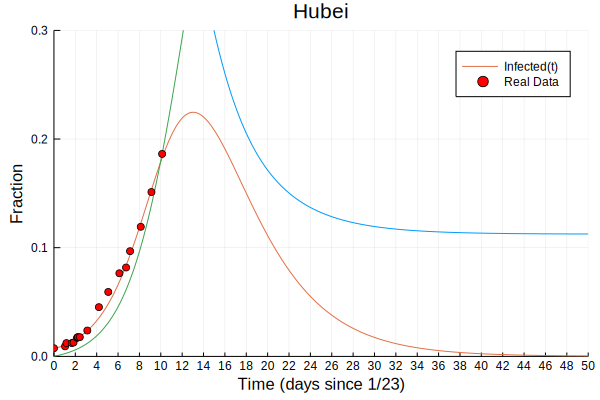

In [9]:
# solve ODE using the updated parms
@show parms
prob = ODEProblem(sir_ode!, init, tspan, parms)
sol = solve(prob, Tsit5())
plot(sol, xlabel="Time (days since 1/23)", ylabel="Fraction", yrotation=0,
    xticks = (range(tspan..., step=48), range(0, tspan[2]÷24, step=2)),
    label = ["" "Infected(t)" ""])
scatter!(times, Is, color=:red, label = "Real Data")


# scatter!([1], [Is[1]])
ylims!((-0.0001, 0.3))
title!("Hubei")

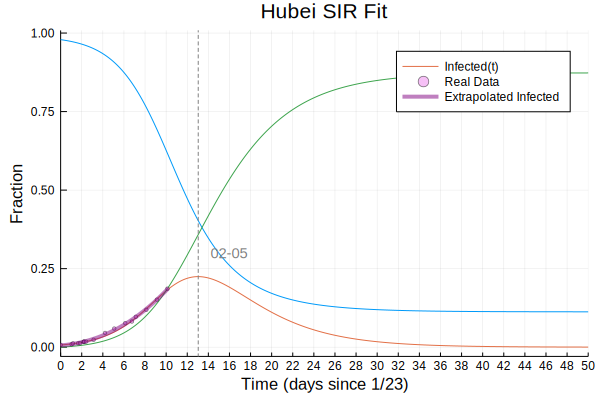

In [10]:
plot(sol, xlabel="Time (days since 1/23)", ylabel="Fraction", yrotation=0,
    xticks = (range(tspan..., step=48), range(0, tspan[2]÷24, step=2)),
    label = ["" "Infected(t)" ""])

# extrapolated data
scatter!(times, Is, color = :violet, label = "Real Data", alpha = 0.5, markersize = 2)
plot!(t_points, I_points, color=:purple, linewidth = 4, linealpha = 0.5, label = "Extrapolated Infected")

vline_x = argmax([sol(x)[2] for x=1:tspan[2]]) # find time when infected is max

vline!([vline_x], linestyle = :dash, color = :grey, label = "")
annotate!(vline_x+70, 0.3, text("$(DateTime("2020-1-23") + Hour(vline_x))"[6:10], 10, :grey))
title!("Hubei SIR Fit")

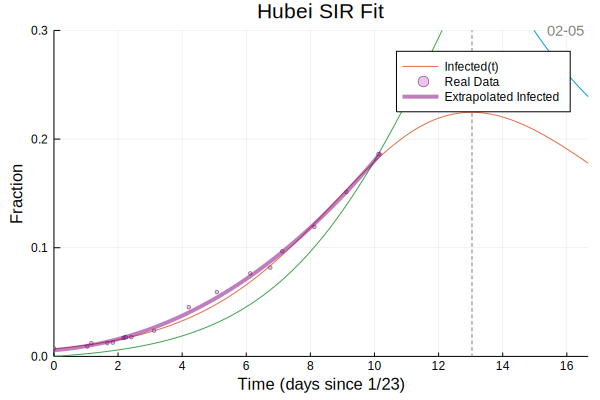

In [11]:
xlims!((0, 400))
ylims!((0, 0.3))